In [2]:
import os, shutil
from keras import models
from keras import layers
from keras import losses
from keras import Input
from keras import Model
from keras import backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn

Using TensorFlow backend.


In [3]:
full_data = pd.read_csv("../data_files/extant_training_set_0to40.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

full_labels = pd.read_csv("../data_files/extant_training_set_0to40_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [4]:
# log R0 sample rate and migration rate
full_labels[:,5:8] = np.log(full_labels[:,5:8])

In [5]:
# randomize data order
randomized_idx = np.random.permutation(full_data.shape[0])
full_data = full_data[randomized_idx,:]
full_labels = full_labels[randomized_idx,:]

In [6]:
# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 1000 
num_validation = 5000  # found early stoping epoch number using 10000 validation
num_sample = full_data.shape[0]

num_tips = cn.get_num_tips(full_data)
subsample_prop = full_data[:,(max_tips-1) * 7]
mu = full_data[:,(max_tips - 3) * 7]


In [7]:
# normalize labels
labels = full_labels[0:num_sample,5:8]
norm_train_labels, train_label_means, train_label_sd = cn.normalize(labels[(num_test + num_validation):,:])
norm_validation_labels = cn.normalize(labels[num_test:num_test + num_validation,], (train_label_means, train_label_sd))
norm_test_labels = cn.normalize(labels[:num_test,], (train_label_means, train_label_sd))


In [8]:
# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  full_labels[0:num_sample,8], 
                                  full_labels[0:num_sample,9])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


In [9]:
# dev create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)


(105157, 499, 7) (105157, 5, 2)
(5000, 499, 7) (5000, 5, 2)
(1000, 499, 7) (1000, 5, 2)


In [21]:
## define pinball loss functions
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis=-1)

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

In [49]:
def create_model():
    input_treeLocation_tensor = Input(shape = train_treeLocation_tensor.shape[1:3])
    w1 = layers.Conv1D(64, 3, strides = 1, activation = 'relu', padding = 'same')(input_treeLocation_tensor)
    w = layers.Conv1D(64, 5, activation = 'relu', padding = 'same')(w1)
    #w = layers.MaxPooling1D(pool_size = 3, stride = 1)(w)
    w = layers.Conv1D(96, 5, activation = 'relu', padding = 'same')(w)
    w = layers.Conv1D(128, 5, activation = 'relu', padding = 'same')(w)
    w = layers.Conv1D(256, 7, activation = 'relu', padding = 'same')(w)
    w_global_avg = layers.GlobalAveragePooling1D(name = 'w')(w)

    w_stride = layers.Conv1D(64, 7, strides = 3, activation = 'relu', padding = 'same')(w1)
    w_stride = layers.Conv1D(96, 9, strides = 6, activation = 'relu', padding = 'same')(w_stride)
    w_stride_global_avg = layers.GlobalAveragePooling1D(name = 'w_stride_global_avg')(w_stride)

    # tree + geolocation dilated
    w_dilated = layers.Conv1D(32, 3, dilation_rate = 2, activation = 'relu', padding = "same")(w1)
    w_dilated = layers.Conv1D(64, 5, dilation_rate = 4, activation = 'relu', padding = "same")(w_dilated)
    w_dilated = layers.Conv1D(128, 7, dilation_rate = 8, activation = 'relu', padding = "same")(w_dilated)
    w_dilated_global_avg = layers.GlobalAveragePooling1D(name = 'w_dilated_global_avg')(w_dilated)

    # prior known parameters and data statistics
    input_priors_tensor = Input(shape = train_prior_tensor.shape[1:3])
    priors = layers.Flatten()(input_priors_tensor)
    priors = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling', name = 'prior1')(priors)

    # concatenate all above -> deep fully connected network
    concatenated_wxyz = layers.Concatenate(axis = 1, name = 'all_concatenated')([w_stride_global_avg,
                                                                                 w_global_avg,
                                                                                 w_dilated_global_avg,
                                                                                 priors])

    wxyz = layers.Dense(256, activation = 'relu', kernel_initializer = 'VarianceScaling')(concatenated_wxyz)

    lower_dense = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
    lower_dense = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(lower_dense)
    lower_dense = layers.Dense(16, activation = 'relu', kernel_initializer = 'VarianceScaling')(lower_dense)
    lower_q_output = layers.Dense(3, name = "lower_output")(lower_dense)
    
    upper_dense = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
    upper_dense = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(upper_dense)  
    upper_dense = layers.Dense(16, activation = 'relu', kernel_initializer = 'VarianceScaling')(upper_dense)  
    upper_q_output = layers.Dense(3, name = "upper_output")(upper_dense)
    
    return Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
                outputs = [lower_q_output, upper_q_output])
 

ERROR! Session/line number was not unique in database. History logging moved to new session 3887


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 218s 2ms/step - loss: 0.0753 - lower_output_loss: 0.0483 - upper_output_loss: 0.0269 - val_loss: 0.0568 - val_lower_output_loss: 0.0356 - val_upper_output_loss: 0.0209
Epoch 2/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.0439 - lower_output_loss: 0.0257 - upper_output_loss: 0.0182 - val_loss: 0.0357 - val_lower_output_loss: 0.0201 - val_upper_output_loss: 0.0153
Epoch 3/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.0355 - lower_output_loss: 0.0198 - upper_output_loss: 0.0157 - val_loss: 0.0402 - val_lower_output_loss: 0.0225 - val_upper_output_loss: 0.0174
Epoch 4/20
105157/105157 [==============================] - 221s 2ms/step - loss: 0.0343 - lower_output_loss: 0.0190 - upper_output_loss: 0.0152 - val_loss: 0.0329 - val_lower_output_loss: 0.0178 - val_upper_output_loss: 0.0148
Epoch 5/20
105157/105157 [============

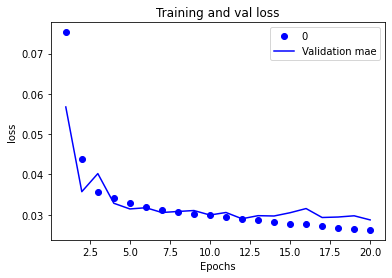

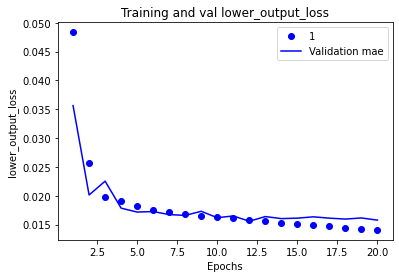

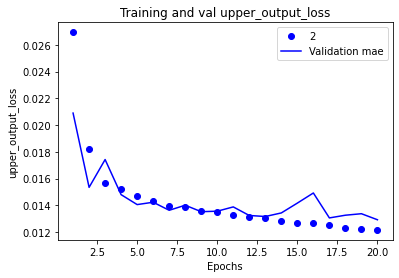

In [50]:
# instantiate MODEL
# set inner quantile
qq = 0.95

mymodel_95q = create_model()
mymodel_95q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_95q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)


In [51]:
# SAVE MODEL to FILE
import csv

# save normalization coefs
all_means = np.append(train_label_means, train_aux_priors_means)
all_sd = np.append(train_label_sd, train_aux_priors_sd)
with open('trained_quantile_CNN/cqr_train_extant_normalization_label_mean_sd.csv', 'w') as file:
    the_writer = csv.writer(file)
    the_writer.writerow(["mean_sd","R0","log_sample_rate", "log_migration_rate", 
                                "mu", "subsample_proportion", "num_tips",
                                "tmrca", "mean_bl"])
    
    the_writer.writerow(np.append("mean", all_means))
    the_writer.writerow(np.append("sd", all_sd))


# store model
mymodel_95q.save("trained_quantile_CNN/cqr95_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 238s 2ms/step - loss: 0.1190 - lower_output_loss: 0.0720 - upper_output_loss: 0.0470 - val_loss: 0.0704 - val_lower_output_loss: 0.0401 - val_upper_output_loss: 0.0299
Epoch 2/20
105157/105157 [==============================] - 236s 2ms/step - loss: 0.0645 - lower_output_loss: 0.0355 - upper_output_loss: 0.0290 - val_loss: 0.0618 - val_lower_output_loss: 0.0337 - val_upper_output_loss: 0.0277
Epoch 3/20
105157/105157 [==============================] - 241s 2ms/step - loss: 0.0596 - lower_output_loss: 0.0326 - upper_output_loss: 0.0270 - val_loss: 0.0578 - val_lower_output_loss: 0.0317 - val_upper_output_loss: 0.0258
Epoch 4/20
105157/105157 [==============================] - 238s 2ms/step - loss: 0.0571 - lower_output_loss: 0.0312 - upper_output_loss: 0.0260 - val_loss: 0.0566 - val_lower_output_loss: 0.0302 - val_upper_output_loss: 0.0260
Epoch 5/20
105157/105157 [============

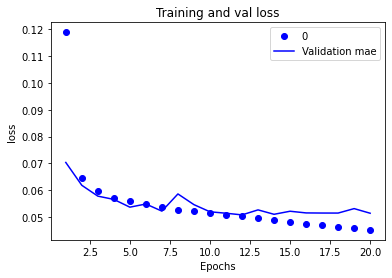

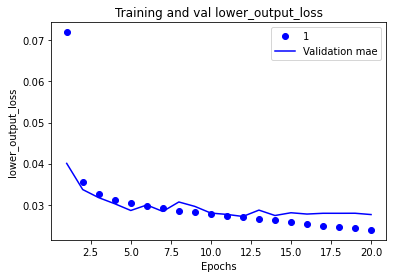

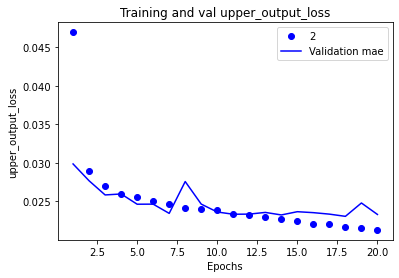

In [40]:
# instantiate MODEL
# set inner quantile
qq = 0.90

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_90q = create_model()
mymodel_90q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_90q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_90q.save("trained_quantile_CNN/cqr90_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.2167 - lower_output_loss: 0.1288 - upper_output_loss: 0.0879 - val_loss: 0.1276 - val_lower_output_loss: 0.0670 - val_upper_output_loss: 0.0598
Epoch 2/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.1220 - lower_output_loss: 0.0652 - upper_output_loss: 0.0568 - val_loss: 0.1146 - val_lower_output_loss: 0.0606 - val_upper_output_loss: 0.0533
Epoch 3/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.1129 - lower_output_loss: 0.0601 - upper_output_loss: 0.0528 - val_loss: 0.1089 - val_lower_output_loss: 0.0588 - val_upper_output_loss: 0.0495
Epoch 4/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.1086 - lower_output_loss: 0.0576 - upper_output_loss: 0.0510 - val_loss: 0.1062 - val_lower_output_loss: 0.0564 - val_upper_output_loss: 0.0494
Epoch 5/20
105157/105157 [============

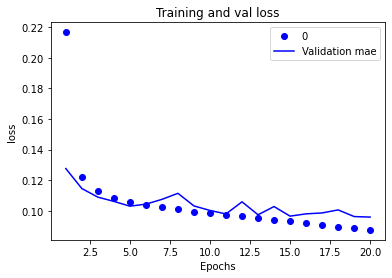

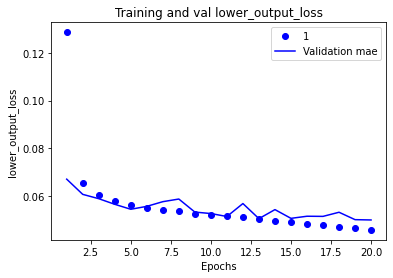

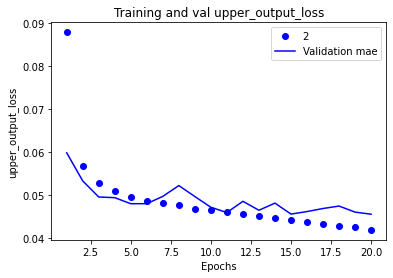

In [41]:
# instantiate MODEL
# set inner quantile
qq = 0.75

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_75q = create_model()
mymodel_75q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_75q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_75q.save("trained_quantile_CNN/cqr75_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.3514 - lower_output_loss: 0.1993 - upper_output_loss: 0.1521 - val_loss: 0.3236 - val_lower_output_loss: 0.1859 - val_upper_output_loss: 0.1379
Epoch 2/20
105157/105157 [==============================] - 226s 2ms/step - loss: 0.3154 - lower_output_loss: 0.1801 - upper_output_loss: 0.1353 - val_loss: 0.3051 - val_lower_output_loss: 0.1749 - val_upper_output_loss: 0.1301
Epoch 3/20
105157/105157 [==============================] - 228s 2ms/step - loss: 0.2356 - lower_output_loss: 0.1282 - upper_output_loss: 0.1074 - val_loss: 0.1862 - val_lower_output_loss: 0.0934 - val_upper_output_loss: 0.0915
Epoch 4/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.1748 - lower_output_loss: 0.0909 - upper_output_loss: 0.0840 - val_loss: 0.1735 - val_lower_output_loss: 0.0880 - val_upper_output_loss: 0.0844
Epoch 5/20
105157/105157 [============

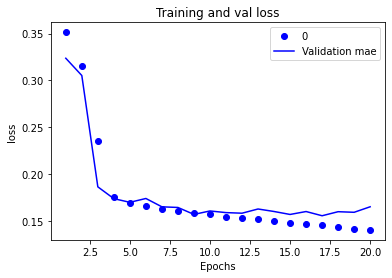

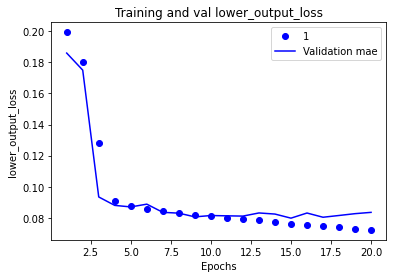

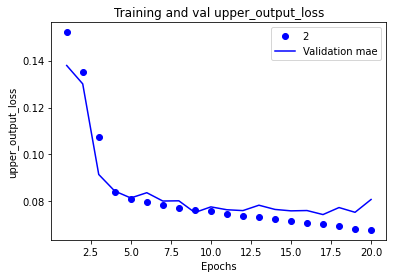

In [42]:
# instantiate MODEL
# set inner quantile
qq = 0.50

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_50q = create_model()
mymodel_50q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_50q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_50q.save("trained_quantile_CNN/cqr50_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.4130 - lower_output_loss: 0.2196 - upper_output_loss: 0.1934 - val_loss: 0.3606 - val_lower_output_loss: 0.1912 - val_upper_output_loss: 0.1693
Epoch 2/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.2353 - lower_output_loss: 0.1202 - upper_output_loss: 0.1151 - val_loss: 0.2128 - val_lower_output_loss: 0.1083 - val_upper_output_loss: 0.1028
Epoch 3/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.2075 - lower_output_loss: 0.1055 - upper_output_loss: 0.1020 - val_loss: 0.1954 - val_lower_output_loss: 0.0984 - val_upper_output_loss: 0.0957
Epoch 4/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.1980 - lower_output_loss: 0.1006 - upper_output_loss: 0.0974 - val_loss: 0.1922 - val_lower_output_loss: 0.0979 - val_upper_output_loss: 0.0933
Epoch 5/20
105157/105157 [============

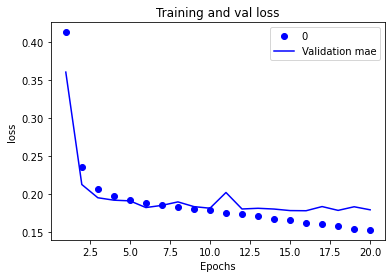

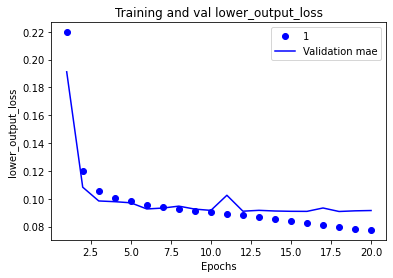

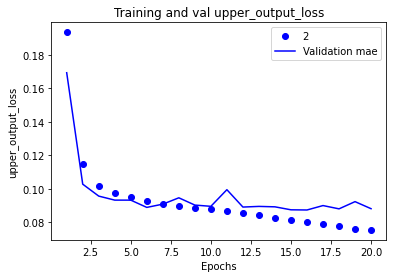

In [43]:
# instantiate MODEL
# set inner quantile
qq = 0.25

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

# mymodel_25q = Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
#                 outputs = [lower_output_R0_sampleRate_migrationRate, upper_output_R0_sampleRate_migrationRate])

mymodel_25q = create_model()
mymodel_25q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_25q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_25q.save("trained_quantile_CNN/cqr25_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 221s 2ms/step - loss: 0.3741 - lower_output_loss: 0.1912 - upper_output_loss: 0.1829 - val_loss: 0.2438 - val_lower_output_loss: 0.1222 - val_upper_output_loss: 0.1193
Epoch 2/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.2344 - lower_output_loss: 0.1183 - upper_output_loss: 0.1161 - val_loss: 0.2218 - val_lower_output_loss: 0.1107 - val_upper_output_loss: 0.1094
Epoch 3/20
105157/105157 [==============================] - 222s 2ms/step - loss: 0.2200 - lower_output_loss: 0.1108 - upper_output_loss: 0.1092 - val_loss: 0.2145 - val_lower_output_loss: 0.1083 - val_upper_output_loss: 0.1058
Epoch 4/20
105157/105157 [==============================] - 223s 2ms/step - loss: 0.2126 - lower_output_loss: 0.1070 - upper_output_loss: 0.1055 - val_loss: 0.2090 - val_lower_output_loss: 0.1048 - val_upper_output_loss: 0.1029
Epoch 5/20
105157/105157 [============

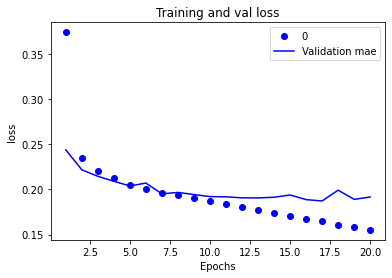

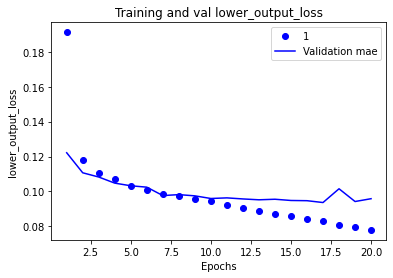

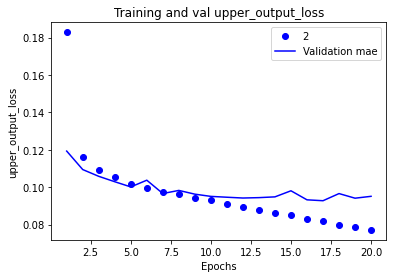

In [44]:
# instantiate MODEL
# set inner quantile
qq = 0.10

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_10q = create_model()
mymodel_10q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_10q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_10q.save("trained_quantile_CNN/cqr10_train_extant_R0_sampleRate_migrationRate.hdf5")


Train on 105157 samples, validate on 5000 samples
Epoch 1/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.3393 - lower_output_loss: 0.1712 - upper_output_loss: 0.1681 - val_loss: 0.2366 - val_lower_output_loss: 0.1179 - val_upper_output_loss: 0.1168
Epoch 2/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.2381 - lower_output_loss: 0.1195 - upper_output_loss: 0.1186 - val_loss: 0.2269 - val_lower_output_loss: 0.1143 - val_upper_output_loss: 0.1106
Epoch 3/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.2265 - lower_output_loss: 0.1137 - upper_output_loss: 0.1128 - val_loss: 0.2301 - val_lower_output_loss: 0.1130 - val_upper_output_loss: 0.1154
Epoch 4/20
105157/105157 [==============================] - 220s 2ms/step - loss: 0.2196 - lower_output_loss: 0.1102 - upper_output_loss: 0.1095 - val_loss: 0.2235 - val_lower_output_loss: 0.1098 - val_upper_output_loss: 0.1117
Epoch 5/20
105157/105157 [============

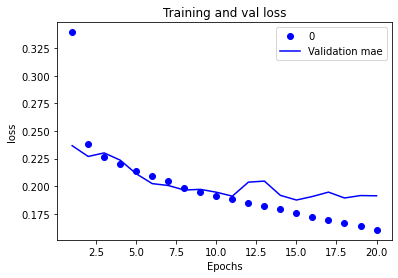

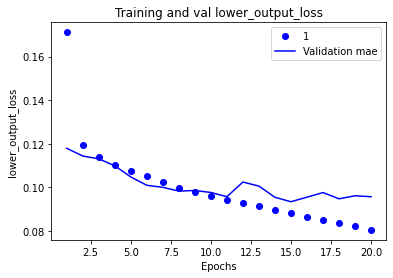

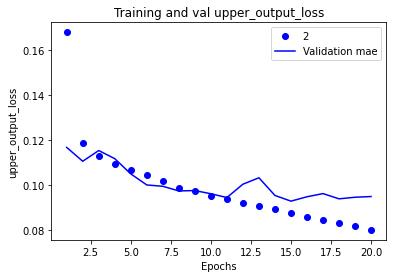

In [45]:
# instantiate MODEL
# set inner quantile
qq = 0.05

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

mymodel_05q = create_model()
mymodel_05q.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper])

history = mymodel_05q.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))



# make history plots
cn.make_history_plot(history)

# store model
mymodel_05q.save("trained_quantile_CNN/cqr05_train_extant_R0_sampleRate_migrationRate.hdf5")


In [ ]:


###### plotting ##########



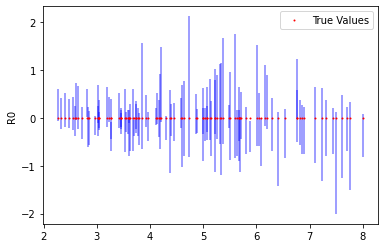

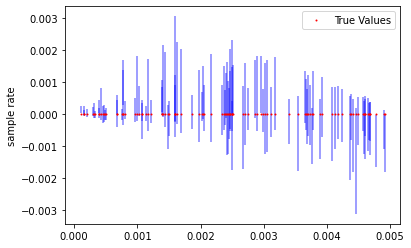

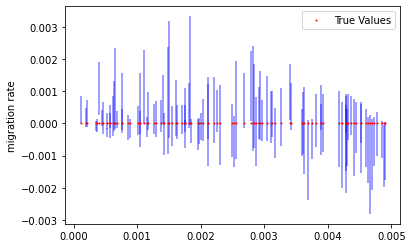

In [52]:
# test data plots

normalized_test_preds_low, normalized_test_preds_up = mymodel_95q.predict([test_treeLocation_tensor[0:100,:,:], 
                                          test_prior_tensor[0:100,:,:]])

# reverse normalization
denormalized_test_labels = cn.denormalize(norm_test_labels[0:100,:], train_label_means, train_label_sd)
denormalized_test_labels = np.exp(denormalized_test_labels)

test_preds_low = cn.denormalize(normalized_test_preds_low, train_label_means, train_label_sd)
test_preds_low = np.exp(test_preds_low)
test_preds_up = cn.denormalize(normalized_test_preds_up, train_label_means, train_label_sd)
test_preds_up = np.exp(test_preds_up)

# make scatter plots
uq.plot_QI(test_preds_low, test_preds_up, denormalized_test_labels, 
                     param_names = ["R0", "sample rate", "migration rate"])
